In [1]:
# Import necessary libraries and modules
import ipywidgets as widgets
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

Textarea(value='{\n    "game": {\n        "pk": 2016020001,\n        "season": "20162017",\n        "type": "R…

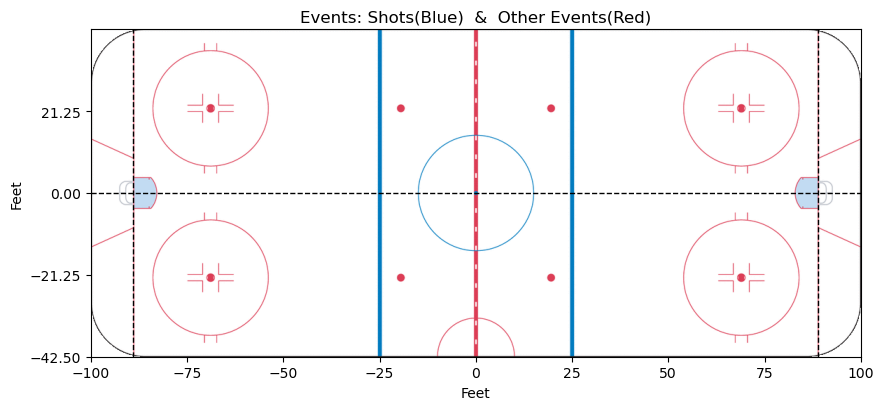

Game Scheduled


In [2]:
# Define the NHLExplorer class to explore and visualize NHL games data
class NHLExplorer:
    """
    Class to explore and visualize NHL game data using interactive widgets.
    
    Attributes:
    season (int): The NHL season year to explore.
    game_type (str): Type of the game ('Regular' or 'Playoffs').

    Methods:
    load_game_data(self, game_id)
    update_year(self, change)
    update_game_type(self, change)
    update_event_range(self)
    display_event(self, game_id, event_idx)
    display_widgets(self)
    browse_games(self)
    """

    def __init__(self, season):
        """
        Initialize the NHLExplorer with a specific season.
        
        Args:
        season (int): The NHL season year to explore.
        """
        
        # Initialize the NHLExplorer with a specific season
        self.season = season
        self.game_type = 'Regular'  # Default game type is Regular
        
        # Create a Dropdown widget for selecting the year
        self.year_dropdown = widgets.Dropdown(options=list(range(2016, 2021)), description='Year:')
        self.year_dropdown.observe(self.update_year, 'value')  

        # Create a Dropdown widget for selecting the game type (Regular or Playoffs)
        self.game_type_dropdown = widgets.Dropdown(options=['Regular', 'Playoffs'], description='Game Type:')
        self.game_type_dropdown.observe(self.update_game_type, 'value')

        # Create an IntSlider widget for selecting the game ID; Maximum is 1271 for our case
        self.game_slider = widgets.IntSlider(min=1, max=1271, description='Game ID:')
        
        # Create an IntSlider widget for selecting the event within the game
        self.event_slider = widgets.IntSlider(min=0, max=0, description='Event:')
        
        # Create a Textarea widget for displaying game information
        self.game_info_text = widgets.Textarea(value='', description='Game Info:', disabled=True, rows=10)

        # Display the widgets
        self.display_widgets()
        

    def load_game_data(self, game_id):
        """
        Load game data based on the selected year, game type, and game ID.
        
        Args:
        game_id (int): The ID of the game to be loaded.
        
        Returns:
        dict: A dictionary containing game data, or None if file not found.
        """
        
        # Load game data based on the selected year, game type, and game ID
        year_of_the_game = str(self.season)
        type_number = 20000 if self.game_type == 'Regular' else 30000  # Use 30000 for playoffs
        json_file = f'{year_of_the_game}0{int(type_number) + int(game_id)}'

        try:
            with open(f'nhl_data/{json_file}.json', 'r') as file:
                return json.load(file)
        except FileNotFoundError:
            return None


    def update_year(self, change):
        """
        Update the selected year and event range when the year is changed.
        
        Args:
        change (object): Contains information about the change in the year.
        """
        
        # Update the selected year and event range when the year is changed
        self.season = change.new
        self.update_event_range()
        

    def update_game_type(self, change):
        """
        Update the selected game type and reset the game slider and event slider when game type changes.
        
        Args:
        change (object): Contains information about the change in the game type.
        """
        
        # Update the selected game type and reset the game slider and event slider when game type changes
        self.game_type = change.new
        self.game_slider.value = 1  # Reset game slider to 1 when game type changes
        self.event_slider.max = 0  # Reset event slider max to 0 when game type changes
        self.update_event_range()
        self.display_widgets()  # Update the widgets to reflect the new game type

        
    def update_event_range(self):
        """
        Update the maximum value of the event slider based on the selected game's data.
        """
        
        # Update the maximum value of the event slider based on the selected game's data
        if self.season == 2019 and self.game_slider.value > 1082 and self.game_type == 'Regular':
            self.event_slider.value = 0
            self.event_slider.max = 0
            return
        
        game_data = self.load_game_data(self.game_slider.value)
        if game_data is not None:
            all_plays = game_data['liveData']['plays']['allPlays']
            self.event_slider.max = len(all_plays) - 1
            
        else:
            self.event_slider.max = 0

            
    def display_event(self, game_id, event_idx):
        """
        Display the selected event within the game using plots.
        
        Args:
        game_id (int): The ID of the game.
        event_idx (int): The index of the event within the game.
        """
        
        # Display the selected event within the game
        if self.season == 2019 and game_id > 1082 and self.game_type == 'Regular':
            print("Data is unavailable!")
            self.game_info_text.value = "Data is unavailable for this game!"
            return
        
        game = self.load_game_data(game_id)
        if game is None:
            print("Game data not found.")
            return
        
        event = game['liveData']['plays']['allPlays'][event_idx]
        event_coord = event.get('coordinates', {})

        # Create a plot to display the event
        img = mpimg.imread('ice_rink.png')
        fig, ax = plt.subplots(figsize=(10, 4.25))
        ax.imshow(img, extent=[-100, 100, -42.5, 42.5])
        plt.ylim((-42.5, 42.5))
        my_y_ticks = np.arange(-42.5, 42.5, 21.25)
        plt.yticks(my_y_ticks)
        plt.xlabel('Feet')
        plt.ylabel('Feet')
        plt.title('Events: Shots(Blue)  &  Other Events(Red)')
        
        if 'x' in event_coord and 'y' in event_coord:
            x = event_coord['x']
            y = event_coord['y']
            if event['result']['event'] == 'Shot':
                ax.plot(x, y, 'bo', markersize=12)
            else:
                ax.plot(x, y, 'ro', markersize=12)
            ax.text(x + 2, y + 2, f'[{x}, {y}]', fontsize=12, color='black')
            
        # Add horizontal line at y=0
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        # Add vertical lines at x=89 and x=-89 for the nets
        ax.axvline(89, color='black', linestyle='--', linewidth=1)
        ax.axvline(-89, color='black', linestyle='--', linewidth=1)
        
        plt.show()

        print(event.get('result', {}).get('description', 'No event description available.'))
        game_info = game['liveData']['plays']['allPlays'][event_idx] if event_idx > 0 else game['gameData']
        game_info_text = json.dumps(game_info, indent=4)
        self.game_info_text.value = game_info_text

        
    def display_widgets(self):
        """
        Display all the interactive widgets.
        """
        
        # Display all the widgets
        clear_output(wait=True)
        display(widgets.VBox([self.year_dropdown, self.game_type_dropdown, self.game_slider, self.event_slider]))
        display(self.game_info_text)
        self.update_event_range()  # Update the event range when switching game type
        self.display_event(self.game_slider.value, self.event_slider.value)

        
    def browse_games(self):
        """
        Function to browse and display NHL games interactively.
        """
        
        # Function to browse and display NHL games
        def display_data(change):
            self.display_widgets()

        self.game_slider.observe(display_data, 'value')
        self.event_slider.observe(display_data, 'value')
        self.display_widgets()


# Create an instance of NHLExplorer and start browsing games for the 2016 season
explorer = NHLExplorer(2016)
explorer.browse_games()